# Analysing the feature importance

blablabla

## Preparation

In [1]:
%cd ..

/home/jupyter-stefan.beuchert/2022-11-26_version


In [2]:
!pip install --user nltk

In [3]:
#!pip install spacy
#!pip install wasabi==0.9.1
#!python -m spacy download de_core_news_sm

In [4]:
from src.analyzer import sort_tokens_in_categories, get_frequencie, display_frequencies

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import matplotlib.pyplot as plt

import nltk
import spacy

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
german_stop_words = nltk.corpus.stopwords.words('german')

spacy_nlp = spacy.load("de_core_news_sm")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter-stefan.beuchert/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jupyter-
[nltk_data]     stefan.beuchert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter-stefan.beuchert/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jupyter-
[nltk_data]     stefan.beuchert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# config
number_of_features = 10 # the default value
number_of_samples = 5000 # the default value

#source_file = f'data/German_QuAD_test_with_lime/lime_ns_{number_of_samples}_nf_{number_of_features}/Combined_Data_GermanQuAD_explained_lime.json'
source_file = f'data/German_QuAD_test_with_lime/lime_ns_{number_of_samples}_nf_{number_of_features}/Combined_Data_GermanQuAD_test_explained_lime.json'
target_path_for_enhanced_data = f'data/Data_Preparation/lime_ns_{number_of_samples}_nf_{number_of_features}_after_frequency_analysis.json'

### Get Data

In [6]:
all_data_df = pd.read_json(source_file)

test_data_df = all_data_df[all_data_df['usage'] == 'test']

# remove rows nan values
len_test_data_df = len(test_data_df)
test_data_cleaned_df = test_data_df.dropna()

# get explanations as df
test_data_cleaned_df['explanation'] = [pd.DataFrame(explanation_object) for explanation_object in test_data_cleaned_df['explanation'].tolist()]

# remove rows with empty explanations
test_data_cleaned_df['not_explainable_tmp'] = [exp.empty for exp in test_data_cleaned_df['explanation'].tolist()]
test_data_cleaned_df = test_data_cleaned_df[~test_data_cleaned_df['not_explainable_tmp']]
test_data_cleaned_df = test_data_cleaned_df.drop('not_explainable_tmp', axis=1)

# get columns with tokens as lower
for index, row in test_data_cleaned_df.iterrows():
    old_df = row['explanation']
    old_df['token_lower'] = old_df['lime_token'].str.lower()
    row['explanation'] = old_df

len_test_data_dropna_df = len(test_data_cleaned_df)

print(f'{len_test_data_df - len_test_data_dropna_df} of the {len_test_data_df} have been droped because the contained *None* values. {len_test_data_dropna_df} rows remaining')


# set index to unique question_id

if(test_data_cleaned_df['question_id'].is_unique):
    test_data_cleaned_df.set_index('question_id', inplace=True)
else:
    print('WARINGIN!!!! question_ids are not unique')
    
test_data_cleaned_df.head(3)

28 of the 2204 have been droped because the contained *None* values. 2176 rows remaining


,question,answers,context,document_id,is_impossible,usage,prediction,explanation
question_id,,,,,,,,
37495,Wie viele Amerikaner fühlen sich mehr als eine...,"[{'answer_id': 37854, 'document_id': 41057, 'q...",Race__United_States_Census_\n\n=== „Race“ ===\...,41057,False,test,fast sieben Millionen,position_id lime_token question_or_cont...
36553,Wer wanderte nach North Carolina Anfang des 20...,"[{'answer_id': 36895, 'document_id': 40789, 'q...",North_Carolina\n\n==== Europäische Amerikaner ...,40789,False,test,eine Gruppe orthodoxer Einwanderer aus der Ukr...,position_id lime_token question_or_contex...
36597,Was gehört zum Stadtkirchenverband Hannover?,"[{'answer_id': 36938, 'document_id': 40797, 'q...",Hannover\n\n==== Evangelisch-lutherische Kirch...,40797,False,test,Alle landeskirchlichen evangelischen Kirchenge...,position_id lime_token question...


### Enhance Data

In [7]:
# get tfidf score
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer = lambda text: text, 
                               # adding a dummy tokenizer so the vecotrizer can work with already tokenized inputs 
                               lowercase=False
                                  )

#explanation_df_list[1]['lime_token'].tolist()

# get corpus
corpus = [exp['token_lower'].tolist() for  exp in test_data_cleaned_df['explanation'].tolist()]

tfidfs = tfidf_vectorizer.fit_transform(corpus)

tfidf_score_dict_df = pd.DataFrame(tfidfs.toarray().transpose(),
                   index=tfidf_vectorizer.get_feature_names())

tfidf_score_dict_df.columns = test_data_cleaned_df.index.values.tolist()

# this is a df containing the tfidf score for each token in each initial data point
# the index of the df is the thoken and the column name the question id of the corresponding data point
# tfidf_score_dict_df.head(3)

# add tfidf score to each token of each data point

for question_index, question_row in test_data_cleaned_df.iterrows():
    question_row['explanation']['tfidf_score'] = np.nan
    
    for token_index, token_row in question_row['explanation'].iterrows():
        question_row['explanation'].at[token_index, 'tfidf_score'] = tfidf_score_dict_df.loc[token_row['token_lower']][question_index]

/home/jupyter-stefan.beuchert/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
list_of_explanations = [explanation_object for  explanation_object in test_data_cleaned_df['explanation'].tolist()]
list_of_explanations[0].head(5)

,position_id,lime_token,question_or_context_tag,start_token_weight,end_token_weight,pos_tag,ner_tag,iob_tag,token_lower,tfidf_score
0,0,Wie,question,0.177282,0.222912,ADV,,O,wie,0.077916
1,1,viele,question,0.173381,0.223847,DET,,O,viele,0.018534
2,2,Amerikaner,question,NaN,NaN,NOUN,LOC,B,amerikaner,0.349143
3,3,fühlen,question,NaN,NaN,VERB,,O,fühlen,0.047557
4,4,sich,question,NaN,NaN,PRON,,O,sich,0.092423


In [9]:
for question_index, question_row in test_data_cleaned_df.iterrows():
    question_row['explanation']['start_lime_tfidf_score'] = question_row['explanation']['tfidf_score'] * question_row['explanation']['start_token_weight']
    question_row['explanation']['end_lime_tfidf_score'] = question_row['explanation']['tfidf_score'] * question_row['explanation']['end_token_weight']
    
list_of_explanations[0].head(5)

,position_id,lime_token,question_or_context_tag,start_token_weight,end_token_weight,pos_tag,ner_tag,iob_tag,token_lower,tfidf_score,start_lime_tfidf_score,end_lime_tfidf_score
0,0,Wie,question,0.177282,0.222912,ADV,,O,wie,0.077916,0.013813,0.017368
1,1,viele,question,0.173381,0.223847,DET,,O,viele,0.018534,0.003213,0.004149
2,2,Amerikaner,question,NaN,NaN,NOUN,LOC,B,amerikaner,0.349143,NaN,NaN
3,3,fühlen,question,NaN,NaN,VERB,,O,fühlen,0.047557,NaN,NaN
4,4,sich,question,NaN,NaN,PRON,,O,sich,0.092423,NaN,NaN


In [10]:
# save values with new variable name

data_df = test_data_cleaned_df

# safe data
# data_df.to_json(target_path_for_enhanced_data)

# safe explanation df in list: the df are still linked to the full df and every change on the df in the list will also accure in the big df (shallow copy)
explanations_list = data_df['explanation'].tolist()

### Analysis

#### Token importances

In [11]:
tokens_with_weights_dict = sort_tokens_in_categories(explanations_list)

In [12]:
# total frequence
display_frequencies(tokens_with_weights_dict, max_tokens = 15, mode = 'frq', target = 'word')

,word,count
1533,die,481
1494,der,464
6364,wie,398
6239,was,390
5814,und,338
3071,in,312
3173,ist,288
6229,wann,225
6286,welche,215
6167,von,192


In [13]:
# total frequence without stopwords
display_frequencies(tokens_with_weights_dict, max_tokens = 15, mode = 'frq', target = 'word', remove_stop_words = True)

,word,count
6098,wann,225
6178,wer,182
6296,wurde,172
6005,viele,111
6105,warum,63
4942,seit,54
1945,erste,47
3587,liegt,40
2566,gibt,40
2812,heißt,39


In [14]:
# abs value of tfidf * lime value ranked
display_frequencies(tokens_with_weights_dict, max_tokens = 15, mode = 'weight', target = 'word')

,word,weight,count
3497,kriegsverbrechen,0.065733,2
3131,intelligenz,0.052564,2
6197,vulkan,0.051193,2
419,airport,0.050693,1
979,berchtoldstag,0.048535,2
435,albanien,0.048170,2
2835,hauptnahrungsmittel,0.044047,2
4796,revolutionsregierung,0.041088,2
432,alabama,0.040019,2
4092,nanjing,0.039490,1


In [15]:
# abs value of tfidf * lime value ranked and without stopwords
display_frequencies(tokens_with_weights_dict, max_tokens = 15, mode = 'weight', target = 'word', remove_stop_words = True)

,word,weight,count
3407,kriegsverbrechen,0.065733,2
3050,intelligenz,0.052564,2
6066,vulkan,0.051193,2
418,airport,0.050693,1
959,berchtoldstag,0.048535,2
434,albanien,0.048170,2
2769,hauptnahrungsmittel,0.044047,2
4688,revolutionsregierung,0.041088,2
431,alabama,0.040019,2
3992,nanjing,0.039490,1


In [16]:
# number of data points
number_of_datapoints = len(data_df)
percentile_1 = int(number_of_datapoints * 0.01)
percentile_5 = int(number_of_datapoints * 0.05)
percentile_10 = int(number_of_datapoints * 0.1)

In [17]:
# abs value of tfidf * lime value ranked and without stopwords and percentiles as min_count
display_frequencies(tokens_with_weights_dict, max_tokens = 15, mode = 'weight', target = 'word', 
                    remove_stop_words = True, min_count = percentile_1)

,word,weight,count
16,prozent,0.009721,28
22,wieso,0.006848,27
9,heißt,0.005733,39
21,wer,0.005672,182
20,warum,0.005400,63
19,wann,0.005244,225
11,land,0.004802,25
13,meisten,0.004695,28
12,liegt,0.004640,40
5,erste,0.003836,47


In [18]:
# abs value of tfidf * lime value ranked and without stopwords and percentiles as min_count
display_frequencies(tokens_with_weights_dict, max_tokens = 15, mode = 'weight', target = 'word', 
                    remove_stop_words = True, min_count = percentile_5)

,word,weight,count
2,wer,0.005672,182
1,wann,0.005244,225
0,viele,0.003693,111
3,wurde,0.001954,172
,word,weight,count
1,wer,0.006499,160
0,wann,0.005802,204
2,wurde,0.002515,142
,word,weight,count
,word,weight,count


In [19]:
# abs value of tfidf * lime value ranked and without stopwords and percentiles as min_count
display_frequencies(tokens_with_weights_dict, max_tokens = 15, mode = 'weight', target = 'word', 
                    remove_stop_words = True, min_count = percentile_10)

,word,weight,count
0,wann,0.005244,225
,word,weight,count
,word,weight,count
,word,weight,count
0,wann,0.007286,222
,word,weight,count
,word,weight,count


In [20]:
# looking at POS tags by total frquency
display_frequencies(tokens_with_weights_dict, max_tokens = 15, mode = 'frq', target = 'pos_tag',  remove_stop_words = True)

,pos_tag,count
6,NOUN,5688
10,PROPN,2175
13,VERB,2117
0,ADJ,1367
2,ADV,1246
7,NUM,1009
3,AUX,263
9,PRON,236
5,DET,235
1,ADP,210


In [21]:
# looking at POS tags by weighted average
display_frequencies(tokens_with_weights_dict, max_tokens = 15, mode = 'weight', target = 'pos_tag',  remove_stop_words = True)

,pos_tag,weight,count
8,PART,0.006864,3
10,PROPN,0.005474,2175
9,PRON,0.005139,236
6,NOUN,0.004839,5688
7,NUM,0.003544,1009
13,VERB,0.003278,2117
11,SCONJ,0.003224,23
0,ADJ,0.003108,1367
2,ADV,0.003040,1246
5,DET,0.003035,235


In [22]:
# NER by total frequency
display_frequencies(tokens_with_weights_dict, max_tokens = 15, mode = 'frq', target = 'ner_tag',  remove_stop_words = True)

,ner_tag,count
0,,11140
1,LOC,1195
2,MISC,950
4,PER,826
3,ORG,569
,ner_tag,count
0,,8479
1,LOC,909
2,MISC,678
4,PER,631


In [23]:
# NER by weighted average
display_frequencies(tokens_with_weights_dict, max_tokens = 15, mode = 'weight', target = 'ner_tag',  remove_stop_words = True)

,ner_tag,weight,count
3,ORG,0.005996,569
1,LOC,0.005662,1195
4,PER,0.004672,826
0,,0.003892,11140
2,MISC,0.003860,950
,ner_tag,weight,count
3,ORG,0.008945,424
1,LOC,0.008246,909
4,PER,0.006658,631
2,MISC,0.006242,678


## Visualization

<AxesSubplot: xlabel='word'>

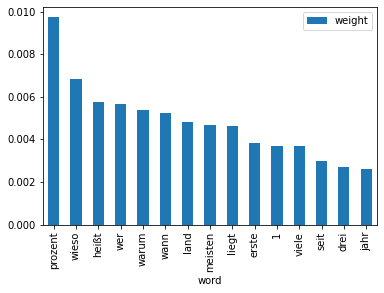

In [24]:
# start tokens with percentile, no stopwords and weigthed average
start_tokens_tfidf_df = get_frequencie(tokens_with_weights_dict['start_tokens_df'], 
                                       max_tokens = 15, mode = 'weight', target = 'word', 
                                       remove_stop_words = True, min_count = percentile_1)

start_tokens_tfidf_df.plot(x = 'word', y = 'weight', kind = 'bar')

<AxesSubplot: xlabel='pos_tag'>

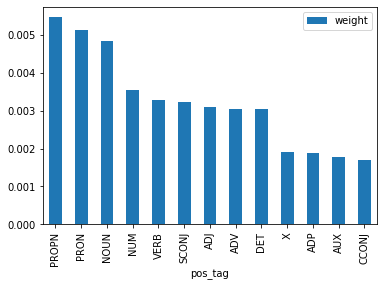

In [25]:
# start pos with percentile, no stopwords and weigthed average
start_pos_tfidf_df = get_frequencie(tokens_with_weights_dict['start_tokens_df'], 
                                       max_tokens = 15, mode = 'weight', target = 'pos_tag', 
                                       remove_stop_words = True, min_count = percentile_1)

start_pos_tfidf_df.plot(x = 'pos_tag', y = 'weight', kind = 'bar')

<AxesSubplot: xlabel='ner_tag'>

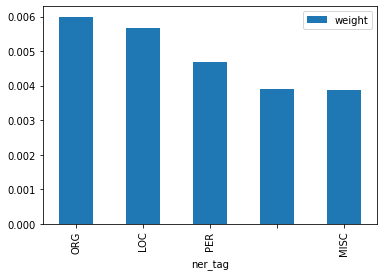

In [26]:
# start ner with percentile, no stopwords and weigthed average
start_ner_tfidf_df = get_frequencie(tokens_with_weights_dict['start_tokens_df'], 
                                       max_tokens = 15, mode = 'weight', target = 'ner_tag', 
                                       remove_stop_words = True, min_count = percentile_1)

start_ner_tfidf_df.plot(x = 'ner_tag', y = 'weight', kind = 'bar')